In [1]:
%cd ..

/hdd/aouadt/these/projets/3d_segm


In [2]:
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import torch

import general.nn.viz.canva as cva
import general.nn.viz.element as viz_element
import general.nn.viz.plot_symbols as ps
import general.nn.viz.element_symbols as es
import general.nn.viz.element_image as ei
import general.nn.viz.element_arrow as ea
import general.nn.viz.element_circle as ec
import general.nn.viz as all_viz
import deep_morpho.morp_operations as mo
import deep_morpho.viz.morp_operations_viz as mov

import deep_morpho.models.bimonn as bimonn
import deep_morpho.viz.element_lui as elui
import deep_morpho.viz.element_bise as ebise
import deep_morpho.viz.bimonn_viz as bviz

def reload_modules():
    for modl in [
        cva, viz_element, ps, es, ei, ea, ec, all_viz, mo, mov,
        bimonn, elui, ebise, bviz
    ]:
        reload(modl)

# Some level sets

In [2]:
N = 200

XX, YY = np.meshgrid(np.arange(N), np.arange(N))

In [3]:
def plot_lvset_ax(ax, im, eps=2e-3):
    mask = np.zeros_like(im)
    im_norm = im / im.max()
    mask[(-eps < im_norm) & (im_norm < eps)] = 1
    mask = np.ma.masked_where(mask == 0, mask)
    ax.imshow(im, cmap='gray')
    ax.imshow(mask, cmap='jet')

In [4]:
def get_circle_fn(center, radius):
    def fn(*x):
        return np.sqrt((x[0] - center[0])**2 + (x[1] - center[1])**2) - radius
    return fn

def Rtheta(theta):
    return np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])

def get_square_fn(center, radius, angle):
    def fn(*x):
        W, L = x[0].shape
        Xs = x[0].reshape(W*L)
        Ys = x[1].reshape(W*L)
        coords = np.vstack((Xs, Ys))
        return (
            np.abs(Rtheta(theta) @ (coords - center[..., np.newaxis])).sum(0) - radius
        ).reshape(W, L)
    return fn


In [71]:
def get_ellipse_fn(center, matrix, radius):
    def fn(*x):
        W, L = x[0].shape
        Z = np.zeros_like(x[0])
        for i in range(W):
            for j in range(L):
                coord = np.array([x[0][i, j], x[1][i, j]]) - center
                coord = coord[:, np.newaxis]
                Z[i, j] = np.sqrt( coord.T @ matrix @ coord) - radius
        return Z
    return fn

In [119]:
A = np.array([
    [4, 2],
    [2, 2]
]) * 5
center = np.array([75, 60])
radius = 100

fn_ellipse = get_ellipse_fn(center, A, radius)
lvset = fn_ellipse(XX, YY)

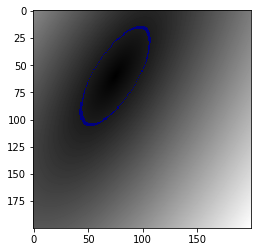

In [120]:
fig, ax = plt.subplots()
plot_lvset_ax(ax, lvset, 5e-3)

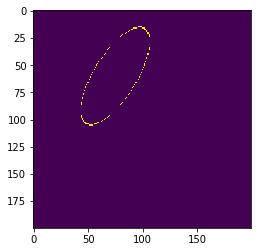

In [123]:
eps = 1e-1
mask = np.zeros_like(lvset)
mask[(-eps < lvset) & (lvset < eps)] = 1
plt.imshow(mask, interpolation='nearest')

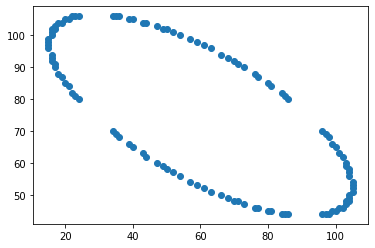

In [124]:
Xs, Ys = np.where(mask)
plt.scatter(Xs, Ys)

In [115]:
c = np.array([100, 100])
r = 50
theta = np.pi / 3

sq_fn = get_square_fn(c, r, theta)

lvset = sq_fn(XX, YY)

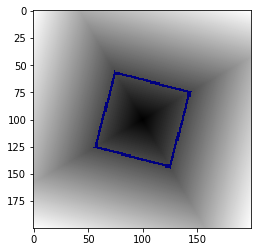

In [6]:
fig, ax = plt.subplots()
plot_lvset_ax(ax, lvset, 2e-2)

In [180]:
c = np.array([150, 100])
r = 20

cir_fn = get_circle_fn(c, r)

lvset = cir_fn(XX, YY)

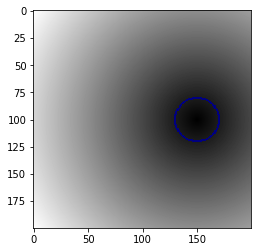

In [182]:
fig, ax = plt.subplots()
plot_lvset_ax(ax, lvset, 1e-2)

# Plot Symbols

<AxesSubplot:>

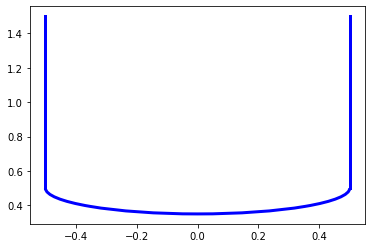

In [8]:
reload_modules()

fig, ax = plt.subplots(1,1)

ps.plot_union_on_ax(ax, [0, 1], color='blue', linewidth=3)

<AxesSubplot:>

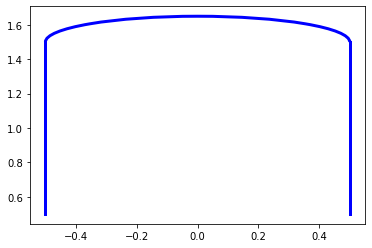

In [42]:
reload_modules()

fig, ax = plt.subplots(1,1)

ps.plot_intersection_on_ax(ax, [0, 1], color='blue', linewidth=3)

<AxesSubplot:>

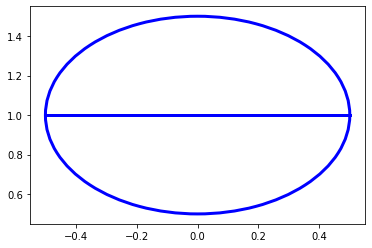

In [9]:
reload_modules()

fig, ax = plt.subplots(1,1)

ps.plot_erosion_on_ax(ax, [0, 1], color='blue', linewidth=3)

<AxesSubplot:>

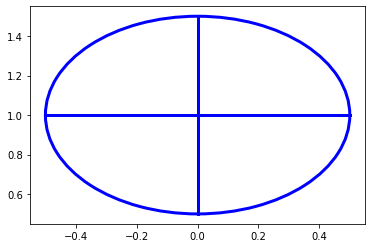

In [47]:
reload_modules()

fig, ax = plt.subplots(1,1)

ps.plot_dilation_on_ax(ax, [0, 1], color='blue', linewidth=3)

# Plot Parallel Morp Ops

In [3]:
# morp_operation = mo.ParallelMorpOperations(
#     operations=[
#         [
#             [("erosion", ("vstick", 7), False), "intersection"],
#             [("dilation", ("dcross", 7), False), "union"]
#         ],
#         [
#             [("dilation", ("scross", 7), False), ("erosion", ("square", 7), False), "intersection"],
#             [("dilation", ("scross", 7), False), ("erosion", ("square", 7), False), "intersection"],
#         ],
#     ]
# )
morp_operation = mo.ParallelMorpOperations.opening(("disk", 3))

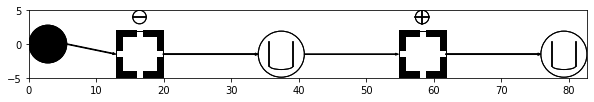

In [4]:
reload_modules()
visu = mov.MorpOperationsVizualiser(morp_operation);
# layer_group = visu.get_layer_group(0)
visu.draw(figsize=(10, 10), axis="on")



'b'

# Plot BiMoNN

In [11]:
net = bimonn.BiMoNN(
    kernel_size=[7,7, 7],
    channels=[1, 2, 3, 1],
    atomic_element="bisel",
    threshold_mode="tanh",
    constant_activation_P=False,
    constant_weight_P=True,
    init_weight_mode="conv",
)

/hdd/aouadt/these/projets/3d_segm/deep_morpho/models/bise.py:85: UserWarning: init weight mode conv not recognized. Classical conv init used.
  warnings.warn(f"init weight mode {self.init_weight_mode} not recognized. Classical conv init used.")


In [40]:
net.layer1.bises[0].weight.shape

torch.Size([2, 1, 7, 7])

In [39]:
new_weights = torch.zeros((2, 1, 7, 7))
new_weights[:, :, :, 3]  = 1
new_weights = (new_weights - .5) * 10
net.layer1.bises[0].set_weights(new_weights)

tensor([[[[-5., -5., -5.,  5., -5., -5., -5.],
          [-5., -5., -5.,  5., -5., -5., -5.],
          [-5., -5., -5.,  5., -5., -5., -5.],
          [-5., -5., -5.,  5., -5., -5., -5.],
          [-5., -5., -5.,  5., -5., -5., -5.],
          [-5., -5., -5.,  5., -5., -5., -5.],
          [-5., -5., -5.,  5., -5., -5., -5.]]],


        [[[-5., -5., -5.,  5., -5., -5., -5.],
          [-5., -5., -5.,  5., -5., -5., -5.],
          [-5., -5., -5.,  5., -5., -5., -5.],
          [-5., -5., -5.,  5., -5., -5., -5.],
          [-5., -5., -5.,  5., -5., -5., -5.],
          [-5., -5., -5.,  5., -5., -5., -5.],
          [-5., -5., -5.,  5., -5., -5., -5.]]]])

In [41]:
net.layer3.coefs

tensor([[0.9089, 0.4229, 1.0983]], grad_fn=<CatBackward>)

In [45]:
for elt in viz.canva.elements['lui_layer_1_chout_2'].input_elements:
    print(elt.)

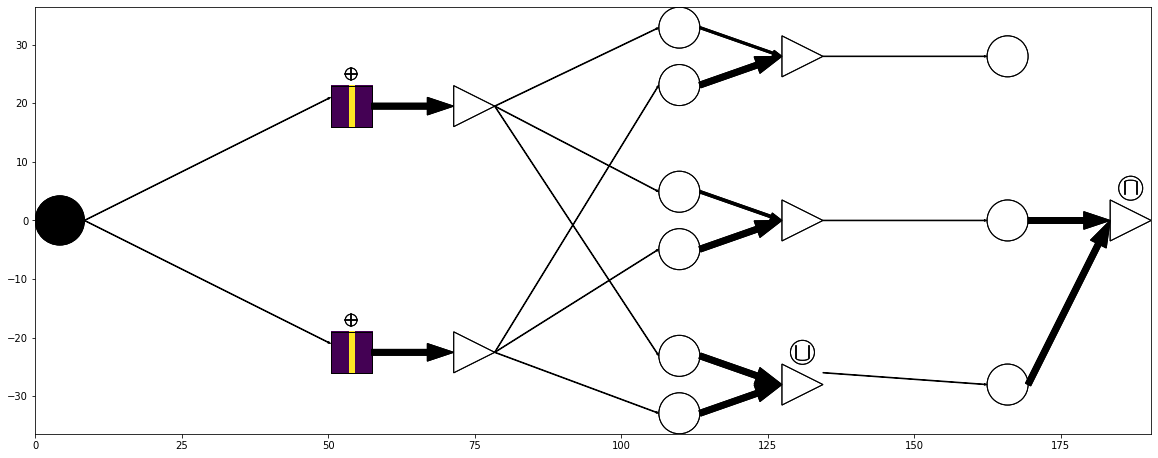

In [40]:
reload_modules()
viz = bviz.BimonnVizualiser(net, mode='selem')
viz.draw(axis="on", figsize=(20, 10))

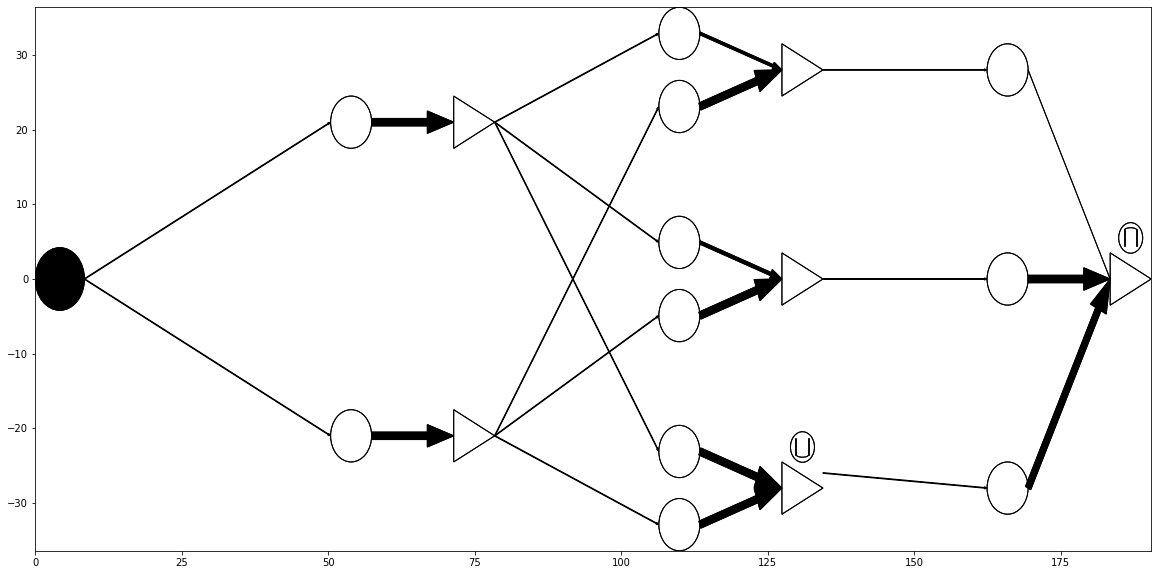

In [24]:
reload_modules()
viz = bviz.BimonnVizualiser(net, mode='selem')
viz.draw(axis="on", figsize=(20, 10))

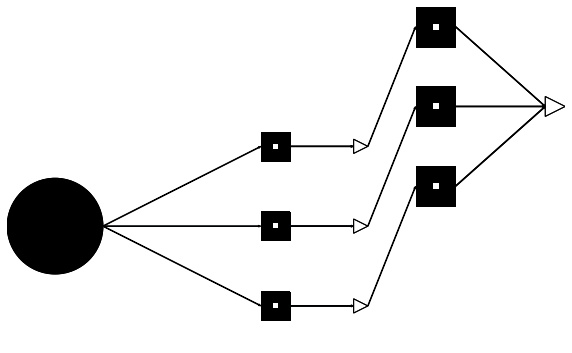

In [88]:
reload_modules()
viz = bviz.BimonnVizualiser(net)
viz.draw(figsize=(10, 10))

In [81]:
viz.box_height

42